In [817]:
import pandas as pd
import numpy as np
import time

In [1333]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [819]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [820]:
mapping = pd.read_csv('CIK-TICKER.csv')

In [1236]:
def quant(col):
    clean_col = col[pd.notna(col)]
    clean_col = pd.DataFrame(clean_col)
    clean_col.columns = ['clean']
    clean_col['labels'] = pd.qcut(clean_col['clean'],q=5, labels=False,precision=2,duplicates = 'drop') #.rank(method='first') #, labels=[1,2,3,4,5]
    
        
    return clean_col

In [821]:
def cosine(A,B):
    if (len(A) < 20) or (len(B) < 20):
        return None
    words_A = ' '.join(A)
    words_B = ' '.join(B)
    l = [words_A,words_B]
    cv = CountVectorizer()
    vectors = cv.fit_transform(l)
    a = vectors.toarray()[0]
    b = vectors.toarray()[1]
    c = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return c

In [822]:
global_words = []
diff = []
starting = []

In [823]:
def CosineSim(words_A, words_B):
    global starting
    w_A = words_A
    w_B = words_B
    
    words_A = set(words_A)
    words_B = set(words_B)
    global global_words
    global diff
    len_A = len(words_A)
    len_B = len(words_B)
    check = [abs(len_A-len_B),(abs(len_A-len_B)*100)/(min(len_A ,len_B))]
    
    if check[0] == 0:
        return None
    
    if check[1] > 75:
        return None

    diff.append(check)
    global_words.append(len_A)
    global_words.append(len_B)
    
    if (len_A < 100) or (len_B < 100):
        return None
    
    if w_A[3] != 'financial':
        return None
    if w_B[3] != 'financial':
        return None
    starting.append(w_A[0:20])
    starting.append(w_B[0:20])
    
    # Compile complete set of words in A or B
    words = list(words_A.union(words_B))
    
    # Determine which words are in A
    vector_A = [1 if x in words_A else 0 for x in words]
    
    # Determine which words are in B
    vector_B = [1 if x in words_B else 0 for x in words]
    
    # Compute cosine score using scikit-learn
    array_A = np.array(vector_A).reshape(1, -1)
    array_B = np.array(vector_B).reshape(1, -1)
    cosine_score = cosine_similarity(array_A, array_B)[0,0]
    
    if cosine_score == 0 or cosine_score == 1:
        cosine_score = np.nan
    
    
    return cosine_score

In [824]:
def JaccardSim(words_A, words_B):
    w_A = words_A
    w_B = words_B
    
    words_A = set(words_A)
    words_B = set(words_B)
    len_A = len(words_A)
    len_B = len(words_B)
    
    check = [abs(len_A-len_B),(abs(len_A-len_B)*100)/(min(len_A ,len_B))]
    
    if check[0] == 0:
        return None
    
    if check[1] > 75:
        return None
    
    if (len_A < 100) or (len_B < 100):
        return None
    
    if w_A[3] != 'financial':
        return None
    if w_B[3] != 'financial':
        return None
    # Count number of words in both A and B
    words_intersect = len(words_A.intersection(words_B))
    
    # Count number of words in A or B
    words_union = len(words_A.union(words_B))
    
    # Compute Jaccard similarity score
    jaccard_score = words_intersect / words_union
    
    if jaccard_score == 0 or jaccard_score == 1:
        jaccard_score = np.nan
    
    return jaccard_score

In [826]:
start = time.time()
i = 0
error_cik = {'File':[],'Rows':[],'Latest':[],'Roll':[]}
for x in mapping['CIK']: #mapping['CIK']
    
    cik_num = str(x)
    
    try:
        data = pd.read_pickle(cik_num+'-new.pkl')
    except:
        error_cik['File'].append(cik_num)
#         print("Error in: No file",cik_num)
        continue
    
    if len(data) < 10:   ## If only 10 rows are present
        error_cik['Rows'].append(cik_num)
#         print("Error in: (<10)",cik_num)
        continue
    
    if int(data['Filing_date'][0][0:4]) < 2019:
        error_cik['Latest'].append(cik_num)
#         print("Error in: (<2019)",cik_num)
        continue
    
    data['Words_prev'] = np.roll(data.Words,-4)    # Remove the bottom four for comparison
    data['Filing_typeroll'] = np.roll(data.Filing_type,-4)
    data = data[:-4]
    
    if not data['Filing_type'].equals(data['Filing_typeroll']): #proceed if, if not store the cik value
        error_cik['Roll'].append(cik_num)
#         print("Error in:",cik_num)
        continue
    
#     print("Ongoing ",i ,":", cik_num)
    
    data['Filing_date'] = pd.to_datetime(data['Filing_date'])  #Convert Filing date to Year-Week format
    data['Year-Week'] = data['Filing_date'].dt.strftime('%Y-%U')
    
    data['Cosine_sim'] = data.apply(lambda row: CosineSim(row['Words'],row['Words_prev']),axis = 1)
    
    data['Jaccard_sim'] = data.apply(lambda row: JaccardSim(row['Words'],row['Words_prev']),axis = 1)
    
    cut_cdata = data[['Year-Week','Cosine_sim']]
    cut_jdata = data[['Year-Week','Jaccard_sim']]
    
    pcut_c = cut_cdata.set_index('Year-Week')
    pcut_j = cut_jdata.set_index('Year-Week')
    
    pcut_c = pcut_c.iloc[::-1]
    pcut_j = pcut_j.iloc[::-1]
    
    pcut_c = pcut_c.pct_change(4)
    pcut_j = pcut_j.pct_change(4)
    
    
    if i == 0:  # Create a DF in first run
        final_cdata = cut_cdata.copy(deep=False)
        final_cdata.rename(columns={'Cosine_sim': cik_num}, inplace=True)
        
        final_jdata = cut_jdata.copy(deep=False)
        final_jdata.rename(columns={'Jaccard_sim': cik_num}, inplace=True)
        
        pfinal_cdata = pcut_c.copy(deep=False)
        pfinal_cdata.rename(columns={'Cosine_sim': cik_num}, inplace=True)
        
        pfinal_jdata = pcut_j.copy(deep=False)
        pfinal_jdata.rename(columns={'Jaccard_sim': cik_num}, inplace=True)
    else:
        final_cdata = pd.merge(final_cdata,cut_cdata,on = 'Year-Week' ,how = 'outer')
        final_cdata.rename(columns={'Cosine_sim': cik_num}, inplace=True)
        
        final_jdata = pd.merge(final_jdata,cut_jdata,on = 'Year-Week' ,how = 'outer')
        final_jdata.rename(columns={'Jaccard_sim': cik_num}, inplace=True)
        
        pfinal_cdata = pd.merge(pfinal_cdata,pcut_c,left_index = True,right_index = True,how = 'outer')
        pfinal_cdata.rename(columns={'Cosine_sim': cik_num}, inplace=True)
        
        pfinal_jdata = pd.merge(pfinal_jdata,pcut_j,left_index = True,right_index = True,how = 'outer')
        pfinal_jdata.rename(columns={'Jaccard_sim': cik_num}, inplace=True)
    
    i = i+1
    if i%100 == 0:
        print(i)

print(time.time() - start)

pfinal_cdata.reset_index(inplace= True)
pfinal_jdata.reset_index(inplace= True)

ctemp = final_cdata.copy(deep = False)
jtemp = final_jdata.copy(deep = False)
pctemp = pfinal_cdata.copy(deep = False)
pjtemp = pfinal_jdata.copy(deep = False)   # Saving a copy if something goes wrong later

100
200
300
400
168.40227818489075


### EDA of results

In [863]:
# final_cdata = ctemp.copy(deep = False)
# final_jdata = jtemp.copy(deep = False)
# pfinal_cdata = pctemp.copy(deep = False)
# pfinal_jdata = pjtemp.copy(deep = False)

In [882]:
c_desc = final_cdata.describe().T
c_desc.describe()

,count,mean,std,min,25%,50%,75%,max
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,45.389549,0.835397,0.057898,0.693129,0.802346,0.842941,0.876027,0.930452
std,11.423255,0.043723,0.018803,0.083238,0.053406,0.045887,0.040669,0.029585
min,10.000000,0.676648,0.022026,0.325807,0.627417,0.678936,0.693798,0.807195
25%,41.000000,0.804830,0.044736,0.644901,0.763998,0.811365,0.848380,0.916452
50%,49.000000,0.836706,0.054932,0.700069,0.805422,0.845406,0.881539,0.936280
75%,54.000000,0.868689,0.068744,0.746989,0.842417,0.877946,0.904899,0.949053
max,61.000000,0.942979,0.143338,0.880411,0.949661,0.966383,0.983283,0.998900


In [865]:
#c_desc[c_desc['max'] < 0.85]
c_desc[c_desc['count'] < 10]

,count,mean,std,min,25%,50%,75%,max
1373715,7.0,0.869029,0.033136,0.807017,0.855425,0.882663,0.887984,0.906702
1095073,1.0,0.876975,NaN,0.876975,0.876975,0.876975,0.876975,0.876975
842162,8.0,0.927735,0.013218,0.907466,0.920182,0.925179,0.940086,0.945452
796343,1.0,0.781017,NaN,0.781017,0.781017,0.781017,0.781017,0.781017
743316,5.0,0.866122,0.220104,0.472663,0.952250,0.964943,0.965276,0.975479
200406,6.0,0.782950,0.022545,0.750296,0.771640,0.780543,0.802279,0.808122
72903,6.0,0.691529,0.025431,0.652925,0.682447,0.688890,0.705604,0.726996
60667,8.0,0.817908,0.017187,0.796209,0.805837,0.815632,0.828662,0.847887
59558,4.0,0.960395,0.019688,0.931957,0.955007,0.967131,0.972519,0.975359
49826,1.0,0.972207,NaN,0.972207,0.972207,0.972207,0.972207,0.972207


In [866]:
#check_c = list(c_desc[c_desc['max'] < 0.85].index)
check_c = (list(c_desc[c_desc['count'] < 10].index))

In [867]:
len(set(check_c))

10

In [856]:
j_desc = final_jdata.describe().T
j_desc.describe()

#j_desc[j_desc['mean'] < 0.8]
j_desc[j_desc['count'] < 10]

#check_j = list(j_desc[j_desc['mean'] < 0.6].index)
check_j = (list(j_desc[c_desc['count'] < 10].index))

In [868]:
final_cdata.drop(check_c,axis = 'columns',inplace = True)
final_jdata.drop(check_c,axis = 'columns',inplace = True)
pfinal_cdata.drop(check_c,axis = 'columns',inplace = True)
pfinal_jdata.drop(check_c,axis = 'columns',inplace = True)

In [870]:
pc_desc = pfinal_cdata.describe().T
pc_desc.describe()

,count,mean,std,min,25%,50%,75%,max
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,48.049881,0.006385,0.076044,-0.163111,-0.033517,0.004705,0.042755,0.207345
std,6.852520,0.009885,0.036856,0.084186,0.020282,0.009647,0.019864,0.162298
min,15.000000,-0.034991,0.016969,-0.613141,-0.164263,-0.030147,0.000000,0.038518
25%,50.000000,0.000615,0.053122,-0.201531,-0.040809,-0.000485,0.029596,0.122541
50%,51.000000,0.005241,0.068526,-0.141895,-0.030980,0.004322,0.039768,0.173971
75%,51.000000,0.011441,0.087778,-0.107248,-0.020903,0.010292,0.052971,0.242189
max,57.000000,0.054850,0.307242,-0.025713,0.005318,0.044090,0.155157,1.797750


In [876]:
pj_desc = pfinal_jdata.describe().T
pj_desc.describe()

,count,mean,std,min,25%,50%,75%,max
count,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,48.049881,0.014801,0.132698,-0.258912,-0.057841,0.008391,0.076540,0.382919
std,6.852520,0.018057,0.063004,0.111118,0.033760,0.016766,0.035132,0.302127
min,15.000000,-0.034567,0.029961,-0.732439,-0.275931,-0.050764,0.000000,0.071389
25%,50.000000,0.003580,0.093379,-0.325320,-0.070669,-0.000252,0.052639,0.221122
50%,51.000000,0.012511,0.118667,-0.232509,-0.054377,0.007299,0.072872,0.316693
75%,51.000000,0.023488,0.154342,-0.181289,-0.035947,0.018097,0.093400,0.455069
max,57.000000,0.110338,0.521293,-0.047379,0.009408,0.075804,0.268934,3.535374


In [910]:
sum = -1     #Removing all the repeating rows from the dataframe
a = set()
b = set()
for x in list(final_cdata['Year-Week']):
    sum +=1
    if x in a:
#         print(final_jdata.index[sum],x)
        b.add(final_jdata.index[sum])
    else:
        a.add(x)

c  = list(b)

In [911]:
sum = -1     #Removing all the repeating rows from the dataframe
a = set()
b = set()
for x in list(pfinal_cdata['Year-Week']):
    sum +=1
    if x in a:
#         print(final_jdata.index[sum],x)
        b.add(final_jdata.index[sum])
    else:
        a.add(x)

pc  = list(b)

In [913]:
final_cdata.drop(c,axis = 'index',inplace = True)
final_jdata.drop(c,axis = 'index',inplace = True)
pfinal_cdata.drop(pc,axis = 'index',inplace = True)
pfinal_jdata.drop(pc,axis = 'index',inplace = True)
#final_cdata.reset_index(inplace=True)

### Changing the column names of final return from stock symbol to CIK


In [920]:
final_returns = pd.read_csv('Final_Returns.csv')  # Price data of stocks

In [922]:
final_returns.set_index('Year-Week',inplace=True)

In [930]:
res = dict(zip(list(mapping['Symbol']),list(mapping['CIK'])))

col_cik = []
for x in final_returns.columns:
    col_cik.append(res[x])

final_returns.columns = col_cik    ### changing column names from stock symbols to cik

In [1170]:
final_returns.columns = [str(x) for x in final_returns.columns]

In [938]:
return_weeks = final_returns.index.to_frame()

In [952]:
return_weeks.index.name = 'Return-Weeks'

In [953]:
return_weeks

,Year-Week
Return-Weeks,
2007-00,2007-00
2007-01,2007-01
2007-02,2007-02
2007-03,2007-03
2007-04,2007-04
...,...
2020-28,2020-28
2020-29,2020-29
2020-30,2020-30


In [964]:
final_cdata = final_cdata.merge(yw, left_on = 'Year-Week',right_on = 'Year-Week',how = 'outer')
pfinal_cdata = pfinal_cdata.merge(yw, left_on = 'Year-Week',right_on = 'Year-Week',how = 'outer')
final_jdata = final_jdata.merge(yw, left_on = 'Year-Week',right_on = 'Year-Week',how = 'outer')
pfinal_jdata = pfinal_jdata.merge(yw, left_on = 'Year-Week',right_on = 'Year-Week',how = 'outer')

### There are some weeks for which the similarity is present but the stock returns are not present. Will delete those weeks after regressing the values to next week.

In [962]:
no_return_week = []
for x in final_cdata['Year-Week']:  
    if x not in yw.iloc[:,0]:
        no_return_week.append(x)

In [963]:
no_return_week

['2006-45',
 '2006-51',
 '2006-44',
 '2006-31',
 '2006-18',
 '2006-10',
 '2006-32',
 '2006-52']

In [969]:
final_cdata.set_index('Year-Week',inplace =  True)
final_jdata.set_index('Year-Week',inplace =  True)
pfinal_cdata.set_index('Year-Week',inplace =  True)
pfinal_jdata.set_index('Year-Week',inplace =  True)

In [974]:
final_cdata.sort_index(axis = 0,inplace= True)
final_jdata.sort_index(axis = 0,inplace= True)
pfinal_cdata.sort_index(axis = 0,inplace= True)
pfinal_jdata.sort_index(axis = 0,inplace= True)

In [1043]:
available_columns = list(final_cdata.describe().columns)

In [1048]:
final_cdata = final_cdata[available_columns]
pfinal_cdata = pfinal_cdata[available_columns]
final_jdata = final_jdata[available_columns]
pfinal_jdata = pfinal_jdata[available_columns]

In [ ]:
final_returns = final_returns.T

In [978]:
# year_list = [2005+x for x in range(1,16)]    #Adding all the missing weeks into the dataframe
# week_list = [x for x in range(53)]

# index_list = []
# for x in year_list:
#     for y in week_list:
#         if y < 10:
#             y = '0' + str(y)
#         if y == 52:
#             if (x == 2006) or (x == 2012) or (x == 2013):
#                 index_list.append(str(x) + '-' + str(y))
#             continue
    
#         if (x == 2020) and (y == 33):
#             break
#         index_list.append(str(x) + '-' + str(y))

# index_l = pd.DataFrame(index_list,columns = ['Year-Week'])

# ffinal_cdata = pd.merge(index_l,final_cdata,on = 'Year-Week' ,how = 'outer')
# ffinal_jdata = pd.merge(index_l,final_jdata,on = 'Year-Week' ,how = 'outer')

# ffinal_cdata.set_index('Year-Week',inplace =  True)
# ffinal_jdata.set_index('Year-Week',inplace =  True)

# ffinal_cdata.sort_index(axis = 1,inplace= True)
# ffinal_jdata.sort_index(axis = 1,inplace= True)

### ADD Weeks from return matrix instead of this

### Limit = 18. Make sure you carry forward the similarity for 18 weeks atmost.

### Done removing misc errors in the data
### Dividing the similarity into 5 Buckets

In [1366]:
def ffill_limit(ffill_days):
    fill_cdata = final_cdata.ffill(limit = ffill_days,axis=0)
    #fill_jdata = final_jdata.ffill(limit = ffill_days,axis=0)
    pfill_cdata = pfinal_cdata.ffill(limit = ffill_days,axis=0)
    #print(pfinal_cdata)
    #pfill_jdata = pfinal_jdata.ffill(limit = ffill_days,axis=0)

    fill_cdata.drop(no_return_week,axis = 'index',inplace=True)
    pfill_cdata.drop(no_return_week,axis = 'index',inplace=True)
    #fill_jdata.drop(no_return_week,axis = 'index',inplace=True)
    #pfill_jdata.drop(no_return_week,axis = 'index',inplace=True)

    fill_cdata = fill_cdata.T
    pfill_cdata = pfill_cdata.T
    #fill_jdata = fill_jdata.T
    #pfill_jdata = pfill_jdata.T

    counter = 0
    for i in fill_cdata.columns:
    #     print(i)
        counter += 1
        q_mat = quant(fill_cdata[i])
        #qj_mat = quant(fill_jdata[i])
        pq_mat = quant(pfill_cdata[i])
        #pqj_mat = quant(pfill_jdata[i])
        if counter == 1:
            Quantile_C = q_mat
            #Quantile_J = qj_mat
            pQuantile_C = pq_mat
            #pQuantile_J = pqj_mat
        else:
            Quantile_C = Quantile_C.merge(q_mat,left_index = True,right_index = True,how='outer')
            #Quantile_J = Quantile_J.merge(qj_mat,left_index = True,right_index = True,how='outer')
            pQuantile_C = pQuantile_C.merge(q_mat,left_index = True,right_index = True,how='outer')
            #pQuantile_J = pQuantile_J.merge(qj_mat,left_index = True,right_index = True,how='outer')

        Quantile_C.drop(['clean'],axis = 'columns',inplace=True)
        Quantile_C.rename({'labels':i},axis = 'columns',inplace=True)
        #Quantile_J.drop(['clean'],axis = 'columns',inplace=True)
        #Quantile_J.rename({'labels':i},axis = 'columns',inplace=True)
        pQuantile_C.drop(['clean'],axis = 'columns',inplace=True)
        pQuantile_C.rename({'labels':i},axis = 'columns',inplace=True)
        #pQuantile_J.drop(['clean'],axis = 'columns',inplace=True)
        #pQuantile_J.rename({'labels':i},axis = 'columns',inplace=True)
    return Quantile_C, pQuantile_C#, Quantile_J, pQuantile_J

### Return based on Quantiles

In [1280]:
def bucket_mul(df,tile):
    
    tile_ret = final_returns.mul(df.eq(tile).replace([False,True],[np.nan,1]))
    num_stocks = tile_ret.count(axis='index')
    w_series = tile_ret.sum()
    ret = []
    for i,j in zip(w_series,num_stocks):
        if j==0:
            j=i
            n=1
        else:
            n=j
        ret.append((i-j)/n)
    ret = pd.DataFrame(ret)
    ret.index = tile_ret.columns
    return ret

In [1281]:
def results(df):
    for i in range(5):
        if i == 0:
            result = bucket_mul(df,i)
            continue
        temp = bucket_mul(df,i) 
        result[str(i)] = temp.iloc[:,0]

    return result
    
# res.drop(0,axis = 'columns',inplace = True)   

In [1332]:
a= 9

In [1377]:
res_dict = {}
res = {}
pres_dict = {}
pres = {}
lag_list = [2,4,8,13,18]
for i in lag_list:
    s_t = time.time()
    c,pc = ffill_limit(i)
    res[i] = results(c)
    res_dict[i] = list((res[i].mean()/res[i].std())*np.sqrt(52))
    pres[i] = results(pc)
    pres_dict[i] = list((pres[i].mean()/pres[i].std())*np.sqrt(52))
    e_t = time.time()
    print(e_t-s_t)

34.258384466171265
34.20665693283081
34.04826593399048
34.36765122413635
34.117905378341675


In [1378]:
pd.DataFrame(res_dict)

,2,4,8,13,18
0,0.756864,0.825091,0.703231,0.773560,0.764733
1,0.670163,0.567660,0.715065,0.667028,0.642662
2,0.698874,0.552112,0.591950,0.613797,0.632864
3,0.686079,0.645795,0.708458,0.721316,0.669343
4,0.841954,0.794856,0.707539,0.718134,0.735820


In [1404]:
r = pd.DataFrame(res[2])

In [1432]:
r.to_csv('return_series.csv')

In [1405]:
(r+1).cumprod()

,0,1,2,3,4
Return-Weeks,,,,,
2007-00,0.991990,1.011877,1.000000,0.993878,0.987914
2007-01,1.002568,1.032192,1.044189,1.015437,1.010652
2007-02,1.001270,0.962557,1.048701,0.987949,1.037208
2007-03,0.990422,0.953955,1.048701,0.963425,1.018606
2007-04,0.996693,0.941726,1.077774,0.990658,1.018250
...,...,...,...,...,...
2020-28,9.225216,7.013588,7.343267,7.325897,12.496202
2020-29,9.333723,7.187834,7.452391,7.523122,12.814656
2020-30,9.366048,7.327754,7.459986,7.555112,13.056251


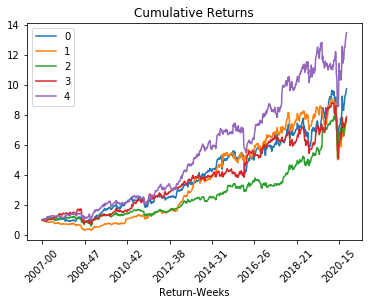

In [1464]:
ret_plot = (r+1).cumprod().plot(rot='45', title = 'Cumulative Returns')
plt.show()

In [1465]:
fig = ret_plot.get_figure()
fig.savefig('returns.pdf',bbox_inches='tight',figsize=(3.0, 2.5))

In [1422]:
ret_plot.figure.savefig('demo-file.pdf')

In [1407]:
pd.DataFrame(pres_dict)

,2,4,8,13,18
0,0.759107,0.830573,0.709084,0.779641,0.770813
1,0.667082,0.564255,0.711383,0.663242,0.638913
2,0.698874,0.576420,0.618239,0.640443,0.659610
3,0.687724,0.647560,0.710354,0.723237,0.671292
4,0.845374,0.798643,0.711607,0.722197,0.739885


In [1408]:
pr = pd.DataFrame(pres[2])

In [1409]:
(pr+1).cumprod()

,0,1,2,3,4
Return-Weeks,,,,,
2007-00,1.000000,1.000000,1.000000,1.000000,1.000000
2007-01,1.010663,1.020076,1.044189,1.021692,1.023016
2007-02,1.009354,0.951259,1.048701,0.994035,1.049897
2007-03,0.998419,0.942757,1.048701,0.969360,1.031068
2007-04,1.004741,0.930672,1.077774,0.996761,1.030707
...,...,...,...,...,...
2020-28,9.299705,6.931265,7.343267,7.371025,12.649085
2020-29,9.409087,7.103465,7.452391,7.569465,12.971435
2020-30,9.441674,7.241744,7.459986,7.601652,13.215985


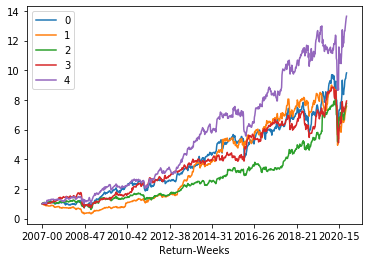

In [1410]:
(pr+1).cumprod().plot()

In [1351]:
orig = pfinal_cdata.copy(deep=False)

In [1352]:
pfinal_cdata = pfinal_cdata.mul(pfinal_cdata.lt(0).replace([True,False],[-1,1]))

In [1346]:
pQuantile_C.mul(pQuantile_C.lt(0).replace([True,False],[-1,1])

,2007-00,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,...,2020-23,2020-24,2020-25,2020-26,2020-27,2020-28,2020-29,2020-30,2020-31,2020-32
100493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
100517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
100885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN
101778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
102729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
97745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,4
98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2


### Return for all the stocks combined

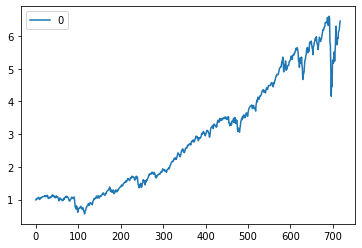

In [1253]:
w = final_returns.sum()
n = final_returns.count()

ret = []
for i,j in zip(w,n):
    if j==0:
        j=i
        x=1
    else:
        x=j
    ret.append((i-j)/x)

(pd.DataFrame(ret) + 1).cumprod().plot()

In [1435]:
(pd.DataFrame(ret) + 1).cumprod()

,0
0,0.991985
1,1.019562
2,1.017218
3,1.016906
4,1.045044
...,...
713,6.132099
714,6.159321
715,6.194116
716,6.369699


In [1330]:
final_returns

Return-Weeks,2007-00,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,...,2020-23,2020-24,2020-25,2020-26,2020-27,2020-28,2020-29,2020-30,2020-31,2020-32
1378946,0.985005,1.012725,0.998205,1.000225,1.016900,1.007334,1.005074,1.004390,0.958479,0.984724,...,0.907063,0.981148,0.904762,1.032318,0.995528,1.019766,1.057269,0.913801,1.049120,1.020318
1374310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.021055,0.988488,0.926684,1.039121,0.962772,1.012125,0.965465,0.980326,1.004105,0.985919
1370946,0.939154,1.002562,1.041986,1.021373,0.989708,1.031889,1.058112,1.009206,0.954703,1.033937,...,0.902431,1.044006,0.983285,0.998891,1.023123,1.093558,1.025403,0.979113,1.098892,1.015500
1370880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.947900,1.054143,0.906615,1.039485,1.051610,1.025520,0.995789,1.161092,1.037086,0.955300
1365135,0.983267,1.020600,0.939447,0.978048,1.099331,0.947003,1.016055,0.988262,0.962997,1.002846,...,0.917312,0.969276,0.976863,1.020843,0.989791,1.030942,1.021828,1.080552,0.958402,1.004297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36966,0.976277,0.996073,0.986447,1.009493,1.081910,1.007548,1.015210,0.998658,0.963502,0.983500,...,0.885617,1.023833,0.897187,1.000000,0.958919,1.040586,1.044420,0.961618,1.053937,1.029683
36270,0.981497,0.999169,0.989693,1.003359,1.024106,0.994442,1.022602,0.998071,0.957113,0.992898,...,0.883698,1.019181,0.904638,1.001294,0.997813,0.989539,1.058498,1.007800,1.015668,1.025462
36047,1.034821,1.023223,0.980315,0.998583,1.025313,1.003692,1.019540,1.064712,1.012707,1.086993,...,0.921775,1.072986,1.367478,0.978367,1.010379,1.008933,1.005902,0.999853,0.997506,0.988528
34903,0.971229,1.045715,1.033807,1.036536,1.027959,1.005080,0.982100,0.984668,0.979421,1.023640,...,0.905062,0.948068,0.976637,1.033466,0.934650,0.980988,0.930639,1.045349,1.032896,1.059257


In [1436]:
(pd.DataFrame(ret) + 1).cumprod().to_csv('b.csv')

In [ ]:
ret

In [1258]:
(np.mean(ret)/np.std(ret))*np.sqrt(52)

0.7208540435413353

In [1257]:
(res.mean()/res.std())*np.sqrt(52)

0    0.756864
1    0.670163
2    0.698874
3    0.686079
4    0.841954
dtype: float64

In [443]:
r = pd.DataFrame(ret)
r.index = final_returns.T.index

In [445]:
r

,0
Year-Week,
2007-00,-0.008047
2007-01,0.027652
2007-02,-0.002347
2007-03,-0.000503
2007-04,0.027672
...,...
2020-28,0.034431
2020-29,0.004335
2020-30,0.005468


In [448]:
m = res.merge(r,left_index= True, right_index = True, how = 'inner')

In [449]:
m

,0_x,2,3,4,5,0_y
2007-00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008047
2007-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.027652
2007-02,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002347
2007-03,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000503
2007-04,0.019754,0.000184,0.043003,0.020639,0.023924,0.027672
...,...,...,...,...,...,...
2020-28,0.032723,0.045351,0.043032,0.026850,0.024455,0.034431
2020-29,0.004379,0.005346,0.004409,-0.000988,0.012212,0.004335
2020-30,-0.002631,0.013033,-0.000308,0.003588,0.015552,0.005468
2020-31,0.030249,0.032407,0.030897,0.028811,0.014542,0.028374


In [465]:
(m.iloc[:,:4].sub(m['0_y'],axis = 'index')).std()

0_x    0.005302
2      0.005423
3      0.005499
4      0.005302
dtype: float64

In [469]:
((m.iloc[:,:4]).mean() - np.mean(ret))/(m.iloc[:,:4].sub(m['0_y'],axis = 'index')).std()

0_x    0.035926
2     -0.033336
3     -0.045669
4     -0.010303
dtype: float64

In [466]:
0.000190/0.005302

0.035835533760844966

In [1437]:
np.mean(ret)

0.0030770498788537043

In [1463]:
(r.mean() - np.mean(ret))/r.sub((ret),axis=0).std()

0    0.033527
1    0.020691
2    0.019913
3    0.020843
4    0.055610
dtype: float64

0    0.023055
1    0.024182
2    0.021227
3    0.025852
4    0.021659
dtype: float64

In [1462]:
0.001204/0.021659

0.055588900687935726

In [1454]:
r

,0,1,2,3,4
Return-Weeks,,,,,
2007-00,-0.008010,0.011877,0.000000,-0.006122,-0.012086
2007-01,0.010663,0.020076,0.044189,0.021692,0.023016
2007-02,-0.001295,-0.067463,0.004321,-0.027070,0.026276
2007-03,-0.010834,-0.008937,0.000000,-0.024823,-0.017934
2007-04,0.006332,-0.012819,0.027723,0.028267,-0.000350
...,...,...,...,...,...
2020-28,0.045474,0.045217,0.042497,0.001487,-0.001579
2020-29,0.011762,0.024844,0.014861,0.026922,0.025484
2020-30,0.003463,0.019466,0.001019,0.004252,0.018853


In [1455]:
ret

[-0.0080147006113439,
 0.027799181694360565,
 -0.002299090920553723,
 -0.00030618577107371426,
 0.027669959058225755,
 0.00015810536678283524,
 0.017052055052304293,
 0.0059709437258003385,
 -0.052544369232562504,
 0.01138280121882092,
 -0.010896566698612147,
 0.03980826177348864,
 -0.01178781733379624,
 0.01607199139031733,
 0.005715633205055578,
 0.018531923326078392,
 0.005387530440572675,
 0.003215198262221947,
 -0.0007199087260632135,
 -0.0004970802238978389,
 0.0016304490994839176,
 0.02542422806661026,
 -0.022692860178965074,
 0.014370733718521354,
 -0.018441965944822385,
 0.003032264270805566,
 0.021790598792566767,
 0.0105239430716659,
 -0.016394451138041156,
 -0.05830618884479243,
 -0.010816176453798163,
 0.02440012121847271,
 -0.008357420179164349,
 0.024372436102344252,
 -0.003538604275174552,
 -0.01489721263629773,
 0.015024520311145532,
 0.028002227628103945,
 0.0007917417664028161,
 0.03565355017864033,
 -0.0006820640407795509,
 -0.042532183983242315,
 0.0276441521575841